# Imports and hyperparameters

In [1]:
import copy
import wandb
import os

import lightning as l
import torch
import torchvision
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from lightly.data import LightlyDataset
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules.heads import VICRegProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import utils
from torch.optim import SGD, Adam

In [2]:
wandb.login()

wandb: Currently logged in as: czifrus-hanna (czhanna-wandb). Use `wandb login --relogin` to force relogin


True

In [3]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '../data/'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
path_to_train = data_dir + "100-bird-species/train/"
path_to_valid = data_dir + "100-bird-species/valid/"
path_to_test = data_dir + "100-bird-species/test/"

In [5]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(path_to_train)
num_classes = len(dataset.classes)
input_size = 512
fc_net = nn.Linear(input_size, num_classes) # Simple FC classifier
lin1_size = 64
lin2_size = 256
lin3_size = 256
deep_net = nn.Sequential( # DNN classifier
    nn.Linear(input_size, lin1_size),
    nn.BatchNorm1d(lin1_size),
    nn.ReLU(),
    nn.Linear(lin1_size, lin2_size),
    nn.BatchNorm1d(lin2_size),
    nn.ReLU(),
    nn.Linear(lin2_size, lin3_size),
    nn.BatchNorm1d(lin3_size),
    nn.ReLU(),
    nn.Linear(lin3_size, num_classes),
)
# classifier_net = deep_net # Choose which classifier to use, fc_net or deep_net
print(num_classes)

525


In [6]:
l.seed_everything(seed)

Seed set to 1


1

# Datasets

In [7]:
train_vicreg_transform = VICRegTransform(
    input_size=32,
    gaussian_blur=0.0,
)

train_classifier_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [8]:
dataset_train_vicreg = LightlyDataset(input_dir=path_to_train, transform=train_vicreg_transform)

dataset_train_classifier = LightlyDataset(
    input_dir=path_to_train, transform=train_classifier_transforms
)

dataset_valid = LightlyDataset(input_dir=path_to_valid, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

In [9]:
dataloader_train_vicreg = torch.utils.data.DataLoader(
    dataset_train_vicreg,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# VICReg class 
SSL-method with pretrained resnet18 backbone

In [10]:
class VICReg(l.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = VICRegProjectionHead(
            input_dim=512,
            hidden_dim=2048,
            output_dim=2048,
            num_layers=4,
        )
        self.criterion = VICRegLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("vicreg_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=0.06)
        return optim

# Classifier class
Defining one classification layer after the backbone

In [11]:
class Classifier(l.LightningModule):
    def __init__(self, backbone, freeze, num_classes, net):
        super().__init__()
        self.backbone = backbone

        if freeze:
            # freeze the backbone
            deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.fc = net

        self.firstTime = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        if self.firstTime:
            self.firstTime = False
            print(type(x))
            print(x)
            print(type(y))
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("classifier_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = Adam(self.fc.parameters(), lr=0.002884)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

# Training

You can load the trained models after each training cell by specifying the appropriate path and commenting out the required lines

## VICReg training

In [ ]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="VICReg", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='vicreg_loss',
    mode='min',
    dirpath = './models/',
    filename = 'best_model_vicreg',
)

ssl_model = VICReg()
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=ssl_model, train_dataloaders=dataloader_train_vicreg)

wandb.finish()

In [ ]:
# Before running change ckpt_path to the correct one
# ckpt_path = "models/best_model_vicreg.ckpt"

# ssl_model = VICReg()
# ssl_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict'])

## Classifier training

In [ ]:
def train_classifier(wandb_name, filename, backbone, freeze, classifier_net, max_eps):
    wandb_logger = l.pytorch.loggers.WandbLogger(
        name=wandb_name, project="Self-supervised learning in-the-wild"
    )
    callback = l.pytorch.callbacks.ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        dirpath = './models/',
        filename = filename,
    )

    classifier = Classifier(backbone, freeze, num_classes, classifier_net)
    trainer = l.pytorch.Trainer(
        max_epochs=max_eps, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]

    )
    trainer.fit(classifier, dataloader_train_classifier, dataloader_valid)

    wandb.finish()

    return classifier

### With ssl pretrained backbone and frozen weights

In [ ]:
model_ssl_frozen = train_classifier("Classifier ssl frozen backbone",
                                    'best_model_with_ssl_frozen',
                                    ssl_model.backbone, True, fc_net, max_epochs)

In [12]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_frozen.ckpt"

ssl_model = VICReg()
model_ssl_frozen = Classifier(ssl_model.backbone, True, num_classes, fc_net)
model_ssl_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
model_ssl_frozen_dnn = train_classifier("Classifier dnn ssl frozen backbone",
                                        'best_model_dnn_with_ssl_frozen',
                                        ssl_model.backbone, True, deep_net, max_epochs)

In [13]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_dnn_with_ssl_frozen.ckpt"

ssl_model = VICReg()
model_ssl_frozen_dnn = Classifier(ssl_model.backbone, True, num_classes, deep_net)
model_ssl_frozen_dnn.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### With ssl pretrained backbone and NOT frozen weights

In [ ]:
model_ssl_not_frozen = train_classifier("Classifier ssl not frozen backbone",
                                        'best_model_with_ssl_not_frozen',
                                        ssl_model.backbone, False, fc_net, max_epochs)

In [14]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_not_frozen.ckpt"

ssl_model = VICReg()
model_ssl_not_frozen = Classifier(ssl_model.backbone, False, num_classes, fc_net)
model_ssl_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [ ]:
model_ssl_not_frozen_dnn = train_classifier("Classifier dnn ssl not frozen backbone",
                                            'best_model_dnn_with_ssl_not_frozen',
                                            ssl_model.backbone, False, deep_net, max_epochs)

In [15]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_dnn_with_ssl_not_frozen.ckpt"

ssl_model = VICReg()
model_ssl_not_frozen_dnn = Classifier(ssl_model.backbone, False, num_classes, deep_net)
model_ssl_not_frozen_dnn.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### Without SSL, but pretrained backbone with frozen weights

In [16]:
# Defining the pretrained backbone
# Running this cell is also required for loading from checkpoint

resnet_pt = torchvision.models.resnet18(pretrained=True)
backbone_pt = nn.Sequential(*list(resnet_pt.children())[:-1])

In [ ]:
model_pretrained_frozen = train_classifier("Classifier pretrained and frozen backbone",
                                           'best_model_with_pretrained_frozen',
                                           backbone_pt, True, fc_net, max_epochs)

In [17]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_frozen.ckpt"

model_pretrained_frozen = Classifier(backbone_pt, False, num_classes, fc_net)
model_pretrained_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [ ]:
model_pretrained_frozen_dnn = train_classifier("Classifier dnn pretrained and frozen backbone",
                                               'best_model_dnn_with_pretrained_frozen',
                                               backbone_pt, True, deep_net, max_epochs)

In [18]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 4 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_dnn_with_pretrained_frozen.ckpt"

model_pretrained_frozen_dnn = Classifier(backbone_pt, False, num_classes, deep_net)
model_pretrained_frozen_dnn.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### Without SSL, but pretrained backbone with NOT frozen weights

In [ ]:
model_pretrained_not_frozen = train_classifier("Classifier pretrained and not frozen backbone",
                                               'best_model_with_pretrained_not_frozen',
                                               backbone_pt, False, fc_net, max_epochs)

In [19]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 6 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_not_frozen.ckpt"

model_pretrained_not_frozen = Classifier(backbone_pt, False, num_classes, fc_net)
model_pretrained_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [ ]:
model_pretrained_not_frozen_dnn = train_classifier("Classifier dnn pretrained and not frozen backbone",
                                                   'best_model_dnn_with_pretrained_not_frozen',
                                                   backbone_pt, False, deep_net, max_epochs)

In [20]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 8 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_dnn_with_pretrained_not_frozen.ckpt"

model_pretrained_not_frozen_dnn = Classifier(backbone_pt, False, num_classes, deep_net)
model_pretrained_not_frozen_dnn.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### With untrained backbone

In [21]:
# Defining the untrained backbone
# Running this cell is also required for loading from checkpoint

resnet_npt = torchvision.models.resnet18(pretrained=False)
backbone_npt = nn.Sequential(*list(resnet_npt.children())[:-1])

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_untrained = train_classifier("Classifier untrained backbone",
                                   'best_model_with_untrained',
                                   backbone_npt, False, fc_net, max_epochs)

In [22]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_npt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_untrained.ckpt"

model_untrained = Classifier(backbone_npt, False, num_classes, fc_net)
model_untrained.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [ ]:
model_untrained_dnn = train_classifier("Classifier dnn untrained backbone",
                                   'best_model_dnn_with_untrained',
                                   backbone_npt, False, deep_net, max_epochs)

In [23]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_npt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_dnn_with_untrained.ckpt"

model_untrained_dnn = Classifier(backbone_npt, False, num_classes, deep_net)
model_untrained_dnn.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

# Evaluation

## Accuracy on test dataset

In [24]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max'
)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)

models = [[model_ssl_frozen, model_ssl_frozen_dnn],
          [model_ssl_not_frozen, model_ssl_not_frozen_dnn],
          [model_pretrained_frozen, model_pretrained_frozen_dnn],
          [model_pretrained_not_frozen, model_pretrained_not_frozen_dnn],
          [model_untrained, model_untrained_dnn]]

titles = ["SSL and frozen backbone",
         "SSL and not frozen backbone",
         "Pretrained and frozen backbone",
         "Pretrained and not frozen backbone",
         "With untrained backbone"]

accuracies_fc = []
accuracies_dnn = []
losses_fc = []
losses_dnn = []
for model_fc, model_dnn in models:
    model_fc.eval()
    model_dnn.eval()
    test_fc = trainer.test(model_fc, dataloader_test)
    test_dnn = trainer.test(model_dnn, dataloader_test)
    accuracies_fc.append(test_fc[0]["test_acc"])
    accuracies_dnn.append(test_dnn[0]["test_acc"])
    losses_fc.append(test_fc[0]["test_loss"])
    losses_dnn.append(test_dnn[0]["test_loss"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |                                                                                       | 0/? [00:00<…

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │     6.353858470916748     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │     6.343297004699707     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │    6.3754963874816895     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │     6.343642234802246     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │     7.166865348815918     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0026666666381061077   │
│         test_loss         │     6.393188953399658     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0019047618843615055   │
│         test_loss         │     7.166865348815918     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0026666666381061077   │
│         test_loss         │     6.393188953399658     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.0011428571306169033   │
│         test_loss         │     6.886592388153076     │
└───────────────────────────┴───────────────────────────┘

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.00800000037997961    │
│         test_loss         │     6.081632614135742     │
└───────────────────────────┴───────────────────────────┘

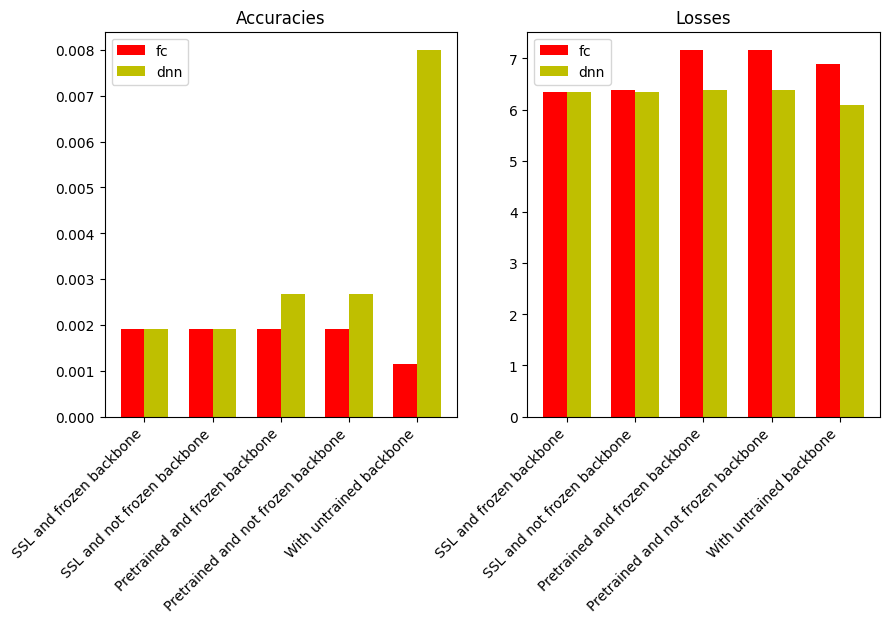

In [26]:
ind = np.arange(5)
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rects1 = ax1.bar(ind, accuracies_fc, width, color='r')
rects2 = ax1.bar(ind + width, accuracies_dnn, width, color='y')
ax1.set_title('Accuracies')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(titles, rotation=45, ha='right')
ax1.legend((rects1[0], rects2[0]), ('fc', 'dnn'))

rects3 = ax2.bar(ind, losses_fc, width, color='r')
rects4 = ax2.bar(ind + width, losses_dnn, width, color='y')
ax2.set_title('Losses')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(titles, rotation=45, ha='right')
ax2.legend((rects3[0], rects4[0]), ('fc', 'dnn'))

plt.show()

## Confusion matrix

In [27]:
def evaluate_model(model, dataloader, num_classes):
    confusion_matrix_metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
    model.eval()
    with torch.no_grad():
        for y_hat, y in trainer.predict(model, dataloader):
            confusion_matrix_metric(y_hat.softmax(dim=-1), y)
    confusion_matrix = confusion_matrix_metric.compute()
    return confusion_matrix

confusion_matrices = []
for model_fc, model_dnn in models:
    confusion_matrices.append(evaluate_model(model_fc, dataloader_test, num_classes))
    confusion_matrices.append(evaluate_model(model_dnn, dataloader_test, num_classes))

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

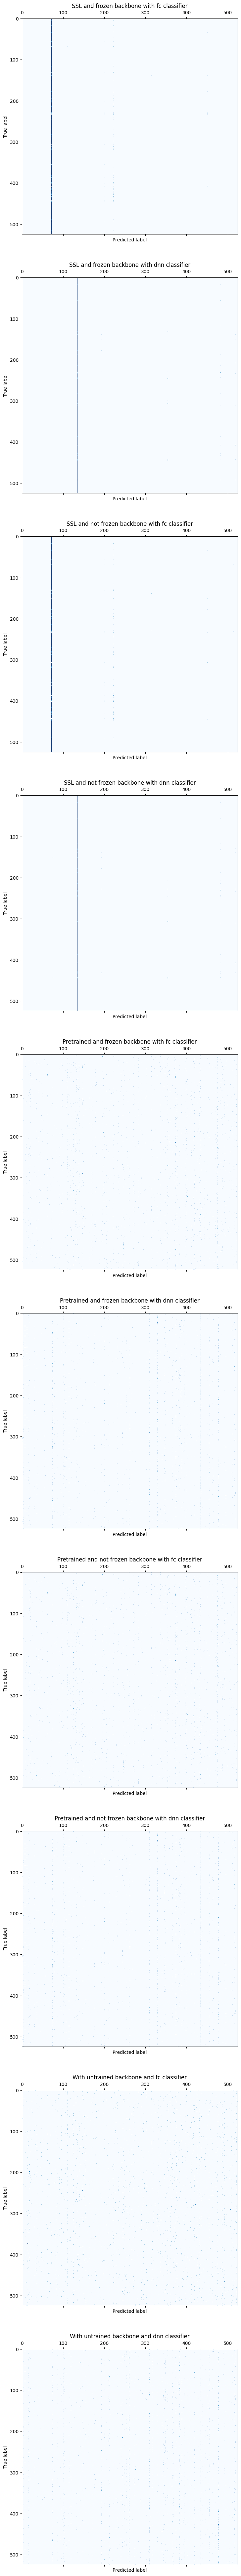

In [30]:
titles = ["SSL and frozen backbone with fc classifier",
          "SSL and frozen backbone with dnn classifier",
         "SSL and not frozen backbone with fc classifier",
         "SSL and not frozen backbone with dnn classifier",
         "Pretrained and frozen backbone with fc classifier",
         "Pretrained and frozen backbone with dnn classifier",
         "Pretrained and not frozen backbone with fc classifier",
         "Pretrained and not frozen backbone with dnn classifier",
         "With untrained backbone and fc classifier",
         "With untrained backbone and dnn classifier"]

fig, axs = plt.subplots(10, 1, figsize=(100, 100))
for i, ax in enumerate(axs):
    ax.matshow(confusion_matrices[i], cmap=plt.cm.Blues)
    ax.set_title(titles[i])
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.show()